# 0.0. IMPORTS

In [ ]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import scipy.stats         as stats
import sklearn.metrics     as metrics
import matplotlib.pyplot as plt


import warnings
import random
import requests
import json
import datetime
import math
import pickle

from IPython.core.display      import HTML
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder
from tabulate                  import tabulate
from boruta                    import BorutaPy
from IPython.display           import Image
from sklearn.model_selection   import train_test_split,cross_val_predict
from sklearn.metrics           import precision_score, recall_score, f1_score
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier 
from sklearn.naive_bayes       import GaussianNB,BernoulliNB
from sklearn.svm               import SVC
from sklearn.tree              import DecisionTreeClassifier
from sklearn.metrics           import roc_curve, auc,accuracy_score
from sklearn.metrics           import precision_recall_curve,recall_score,confusion_matrix
from imblearn.under_sampling   import NearMiss
from sklearn.model_selection   import RandomizedSearchCV,StratifiedKFold
from pycaret.classification    import *
from sklearn.datasets          import make_regression

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## 0.1 Helper Functions

In [ ]:
def numeric_categorical(df,feature,features_reponse):

  plt.subplot(1,2,1)
  aux=df[[feature,features_reponse]].groupby(features_reponse).mean().reset_index()
  ax=sns.barplot(x=features_reponse,y=feature,data=aux)

  plt.subplot(1,2,2)
  aux=df4.copy()
  aux[features_reponse]=aux[features_reponse].apply(lambda x : 1 if x=='sim' else 0)
  correlation=aux[[feature,features_reponse]].corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);

  return ax


def feature_importance(x_train,y_train):

  #model
  model = RandomForestRegressor()

  #fit 
  model.fit(x_train, y_train)

  #get importance
  importance = model.feature_importances_

  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
  #plot feature importance
  plt.bar([x for x in range(len(importance))], importance)

  return plt.show()


def model_perform(y_test,yhat,model_name):

  data=pd.DataFrame({       'model Name':   model_name, 
                            'accuracy'  :   accuracy_score(y_test, yhat),                                                                                                  
                            'precision' :   precision_score(y_test,yhat),
                            'recall'    :   recall_score(y_test,yhat, average='macro'),
                            'f1 score'  :   f1_score(y_test,yhat)                     
                                                                   },index=[0])
  return data


def cross_validation(data,kfold,model_name,model):
  
  accuracy_list=[]
  precision_list=[]
  recall_list=[]
  f1_score_list=[]
  
  
  fim=[]
  inicio=[]  
  razao=data.index.max()/kfold
  for i in range(1,kfold+1):
    fim.append(round(razao*i,2))
    inicio.append(round((razao*i)-razao,2))

  for k in range(0,kfold):

    #Start and end for validation
    validation_start=inicio[k]
    validation_end=fim[k]

    #Filtering in dataset
    aux=data[(data.index>=validation_start) & (data.index<=validation_end)]
    training=data.drop(aux.index,axis=0)
    validation=data[(data.index>=validation_start) & (data.index<=validation_end)]


    #Training and validation dataset
    #Training
    xtraining=training.drop(['fraude'],axis=1)
    ytraining=training['fraude']

    #Validation
    xvalidation=validation.drop(['fraude'],axis=1)
    yvalidation=validation['fraude']

    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    performaces=model_perform(yvalidation,yhat,model_name)
    
    #performance of each KFold iteration
    accuracy_list.append(performaces['accuracy'])
    precision_list.append(performaces['precision'])
    recall_list.append(performaces['recall'])
    f1_score_list.append(performaces['f1 score'])
    


  return pd.DataFrame({ 'Model name':               model_name,  
                        'accuracy CV':              np.round(np.mean(accuracy_list),2).astype(str)+ '+/-' + np.round(np.std(accuracy_list),2).astype(str),                    
                        'precision CV':             np.round(np.mean(precision_list),2).astype(str)+ '+/-' + np.round(np.std(precision_list),2).astype(str),
                        'recall CV':                np.round(np.mean(recall_list),2).astype(str)+ '+/-' + np.round(np.std(recall_list),2).astype(str),
                        'f1 score CV':              np.round(np.mean(f1_score_list),2).astype(str)+ '+/-' + np.round(np.std(f1_score_list),2).astype(str)
                        
                        
                       
                        },index=[0])
  


def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  


def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta


#rescaling
def rescaling(poucos_outliers,muitos_outliers,data):
  
  rs=RobustScaler()
  mms=MinMaxScaler()

  #poucos_outliers
  for i in range(0,len(poucos_outliers)):
    data[poucos_outliers[i]]=mms.fit_transform(data[[poucos_outliers[i]]].values)   

  #muitos_outliers
  for i in range(0,len(muitos_outliers)):
    data[muitos_outliers[i]]=rs.fit_transform(data[[muitos_outliers[i]]].values)     

  return data


def correlacao_features_numericas(numericos,data):

  columns=numericos.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  ax.figure.set_size_inches(18,10)
  ax.set_title('Correlação entre features numéricas',fontsize=14)

  return ax


def correlacao_categorica(data):

  #selecao
  a=data.select_dtypes(include='object')

  #lista 1 , todas correlacoes
  columns=a.columns
  lista=[]
  for i2 in range(0,len(columns)):
    for i in range(0,len(columns)):
      lista.append(cramer_v(a[columns[i2]],a[columns[i]]))

  #lista 2 , correlacoes por features
  lista2=[]
  n_features=len(columns)
  for i in range(0,n_features):

    a=n_features*i
    b=n_features*(i+1)

    lista2.append(lista[a:b])
  
  return lista2

  
def cramer_v(x,y):
  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def estatistica_descritiva(data):

  #selecao
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  # Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['attributes','min','max','range','mean','median','std','skew','kurtosis']) 

  return aux


def curva_roc(y_test,yhat):
  
  fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  return plt.show()



def calcula_limite_superior_e_inferior(data):

  q1=data.quantile(0.25)
  q3=data.quantile(0.75)
  
  iiq=q3-q1

  limite_inferior=q1-1.5*iiq
  limite_superior=q3+1.5*iiq
  
  return [limite_superior,limite_inferior]


def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [ ]:
df_raw=pd.read_csv('/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv')
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_test_deploy=df_raw[df_raw.index<1000]

# 1.0. PASSO 1 - DESCRIPTION OF THE DATA

In [ ]:
#copia do dataframe
df1=df_raw.copy()

## 1.1 Rename Columns

In [ ]:
columns={   'step':'etapa','type':'tipos','amount':'montante','nameOrig':'remetente',
            'oldbalanceOrg':'saldo_inicial_remetente','newbalanceOrig':'saldo_atual_remetente',
            'nameDest':'destinatario','oldbalanceDest':'saldo_inicial_destinatario',
            'newbalanceDest':'saldo_atual_destinatario','isFraud':'fraude','isFlaggedFraud':'fraude_sinalizada'}
df1=df1.rename(columns=columns)
df1.head()

,etapa,tipos,montante,remetente,saldo_inicial_remetente,saldo_atual_remetente,destinatario,saldo_inicial_destinatario,saldo_atual_destinatario,fraude,fraude_sinalizada
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.2 Data Dimensions

In [ ]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 6362620
Number of cols: 11


## 1.3 Data Types

In [ ]:
df1.dtypes

etapa                           int64
tipos                          object
montante                      float64
remetente                      object
saldo_inicial_remetente       float64
saldo_atual_remetente         float64
destinatario                   object
saldo_inicial_destinatario    float64
saldo_atual_destinatario      float64
fraude                          int64
fraude_sinalizada               int64
dtype: object

## 1.4 Check NA

In [ ]:
df1.isna().sum()

etapa                         0
tipos                         0
montante                      0
remetente                     0
saldo_inicial_remetente       0
saldo_atual_remetente         0
destinatario                  0
saldo_inicial_destinatario    0
saldo_atual_destinatario      0
fraude                        0
fraude_sinalizada             0
dtype: int64

## 1.5 Fillout NA

In [ ]:
df1=df1[df1['destinatario'].isna()==False]

## 1.6 Change types

In [ ]:
df1['fraude']=df1['fraude'].astype(str)
df1['fraude_sinalizada']=df1['fraude_sinalizada'].astype(str)

## 1.7 Descriptive Statistical

In [ ]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(include=['object'])

### 1.7.1 Numerical Attributes

In [ ]:
estatistica_descritiva(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,etapa,1.0,7.430000e+02,2.423972e+02,2.433972e+02,239.000,1.423320e+02,0.375177,0.329071
1,montante,0.0,9.244552e+07,1.798619e+05,1.798619e+05,74871.940,6.038582e+05,30.993949,1797.956705
2,saldo_inicial_remetente,0.0,5.958504e+07,8.338831e+05,8.338831e+05,14208.000,2.888242e+06,5.249136,32.964879
3,saldo_atual_remetente,0.0,4.958504e+07,8.551137e+05,8.551137e+05,0.000,2.924048e+06,5.176884,32.066985
4,saldo_inicial_destinatario,0.0,3.560159e+08,1.100702e+06,1.100702e+06,132705.665,3.399180e+06,19.921758,948.674125
5,saldo_atual_destinatario,0.0,3.561793e+08,1.224996e+06,1.224996e+06,214661.440,3.674129e+06,19.352302,862.156508


### 1.7.2 Categorical attributes


In [ ]:
#numero de classes por feature
cat_attributes.apply(lambda x: x.unique().shape[0])

tipos                      5
remetente            6353307
destinatario         2722362
fraude                     2
fraude_sinalizada          2
dtype: int64

Text(0.5, 1.0, 'Número de fraudes por tipos de transferência.')

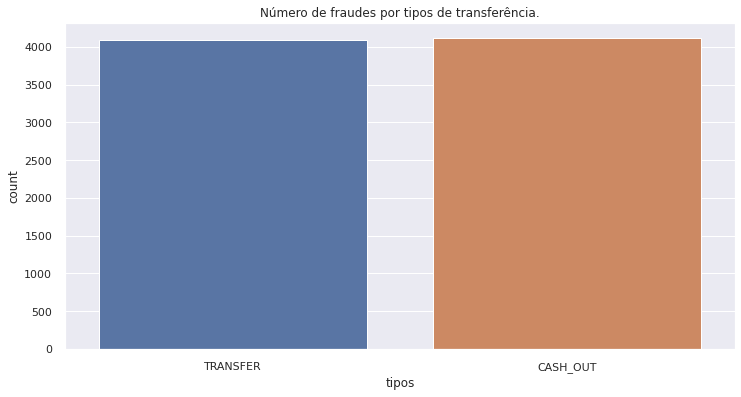

In [ ]:
#plot das features categoricas em relacao a variavel resposta
fraude=df1[df1['fraude']=='1']
ax=sns.countplot(x='tipos', data=fraude)
ax.figure.set_size_inches(12,6)
ax.set_title('Número de fraudes por tipos de transferência.')

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [ ]:
#copia do dataframe
df2=df1.copy()

## 2.1 Mapa mental de Hipoteses

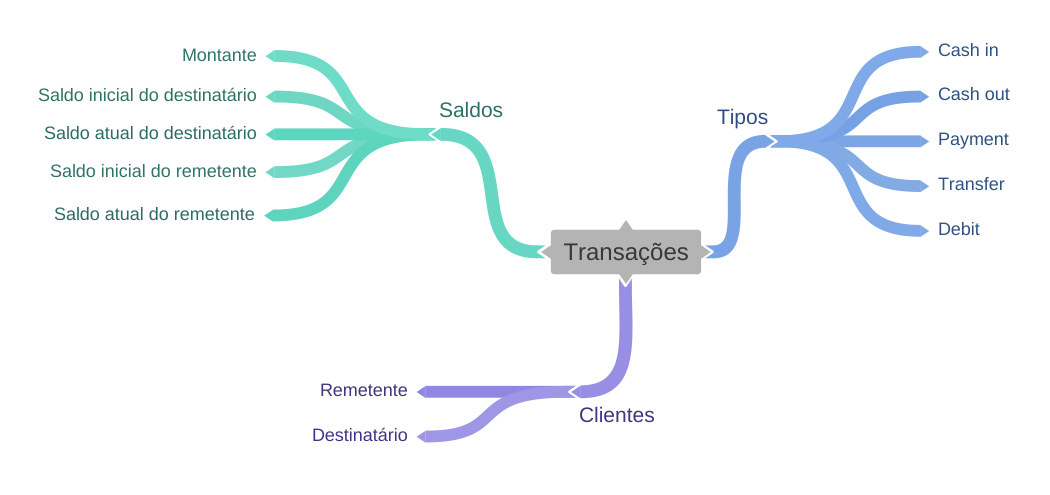

In [ ]:
Image('/content/drive/MyDrive/Transacoes.png')

## 2.1 Criação das hipoteses

### 2.1.1 Hipoteses Saldos

**1.** Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.

**2.** Quanto maior o saldo atual do destinatário, maior é a chance de fraude.

 **3.** Quanto maior o saldo inicial do remetente , maior é a chance de fraude.

**4.** Quanto maior o saldo atual do remetente , maior é a chance de fraude.

### 2.1.2 Hipoteses Clientes

**1.** Há maior chance de fraude quando o nome do remetente for inconsistente.

### 2.1.3 Hipoteses Tipos

**1.** Há maior chance de fraude , quando as transações são dos tipos TRANSFER e CASH OUT.

### 2.1.4 Hipoteses Outros

**1.** Quanto maior  a etapa de medição, maior é a chance de fraude.

## 2.2 Lista final de hipoteses

**H1-**. Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.

**H2-**. Quanto maior o saldo atual do destinatário, maior é a chance de fraude.

**H3-**. Quanto maior o saldo inicial do remetente , maior é a chance de fraude.

**H4-**. Quanto maior o saldo atual do destinatário , maior é a chance de fraude.

**H5-**. Quanto maior o valor do montante , maior é a chance de fraude.


**H6-**. Quanto maior  a etapa de medição, maior é a chance de fraude.

## 2.3 Feature Engineering

In [ ]:
#alerta_montante
df2['alerta_montante']=df2['montante']
df2['alerta_montante']=df2['alerta_montante'].apply(lambda x: '1' if x>300000 else '0')

#alerta_etapa
df2['alerta_etapa']=df2['etapa']
df2['alerta_etapa']=df2['alerta_etapa'].apply(lambda x: '1' if x>367 else '0')

#alerta_saldo_inicial_remetente
df2['alerta_saldo_inicial_remetente']=df2['saldo_inicial_remetente']
df2['alerta_saldo_inicial_remetente']=df2['alerta_saldo_inicial_remetente'].apply(lambda x: '1' if x>1500000 else '0')

# 3.0. PASSO 3 - VARIABLES FILTERING

In [ ]:
#copia do dataframe
df3=df2.copy()

## 3.1. Line Filtering

In [ ]:
df3['fraude']=df3['fraude'].apply(lambda x: 'sim' if x=='1' else 'nao')

# 4.0. PASSO 4 - EXPLORATORY DATA ANALYSIS

In [ ]:
#copia do dataframe
df4=df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

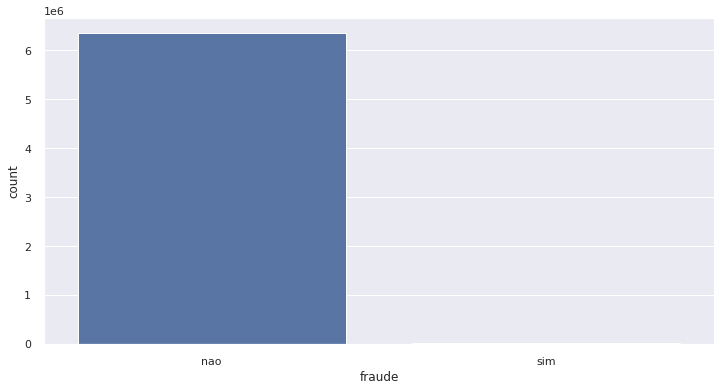

In [ ]:
ax=sns.countplot(df4['fraude'])
ax.figure.set_size_inches(12,6)

### 4.1.2. Numerical Variable

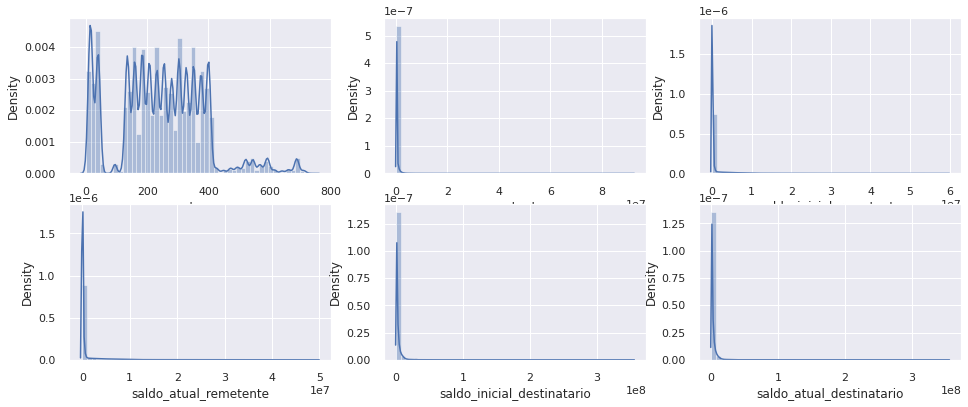

In [ ]:
# num_attributes and cat_attributes
num_attributes=df4[['etapa','montante','saldo_inicial_remetente','saldo_atual_remetente',
                    'saldo_inicial_destinatario','saldo_atual_destinatario']]
cat_attributes=df4[['tipos','destinatario','remetente','fraude','fraude_sinalizada']]

#plot das features numericas
warnings.filterwarnings('ignore')

lista=num_attributes.columns

for i in range(0,len(lista)):

  plt.subplot(len(lista),3,i+1)
  ax=sns.distplot(df4[lista[i]])  
  ax.figure.set_size_inches(16,20)

### 4.1.3. Categorical Variable

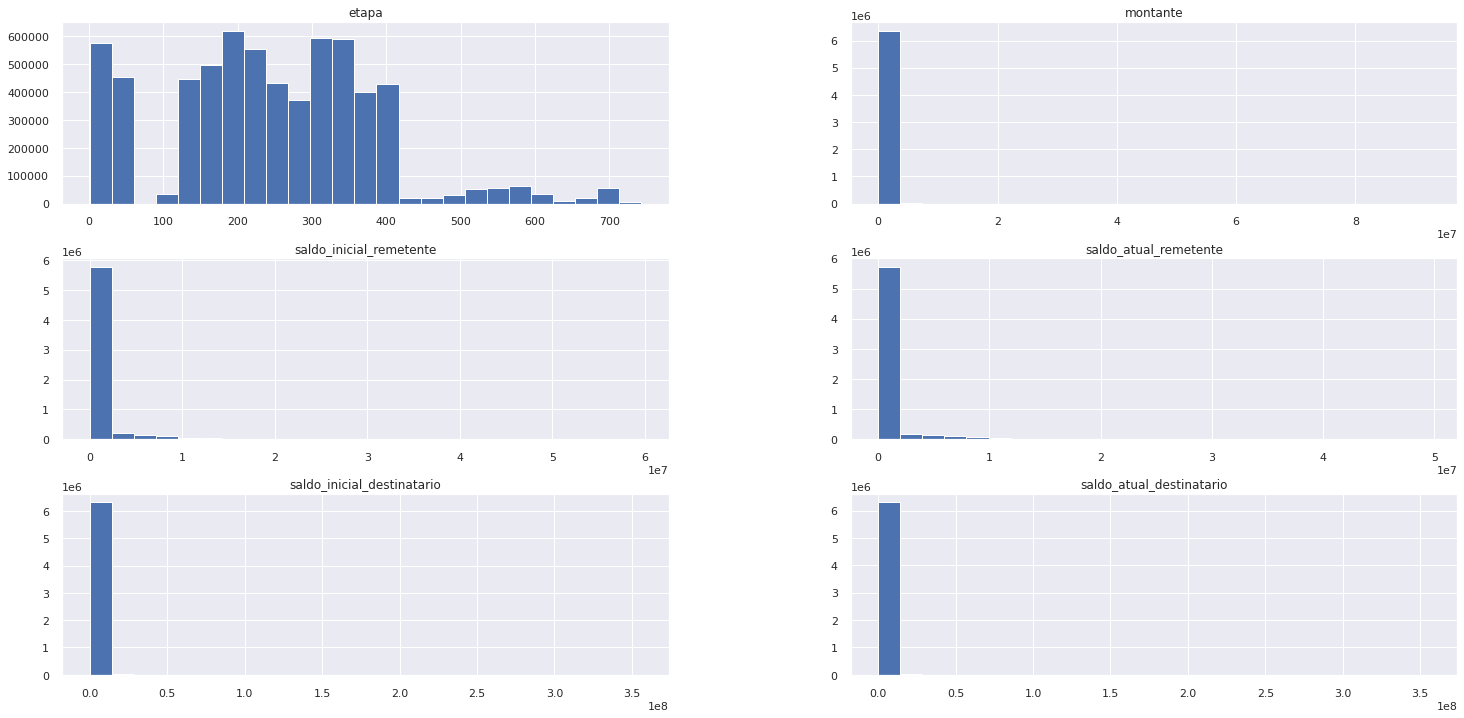

In [ ]:
#separados por fraudes e dados normais
fraudes=cat_attributes[cat_attributes['fraude']=='sim']
normais=cat_attributes[cat_attributes['fraude']=='nao']

num_attributes.hist(bins=25);

Análise:
* O tipos de transações que mais ocorrem fraudes são TRANSFER e CASH_OUT.


## 4.2. Bivariate Analysis

### ***H1***. Quanto maior o saldo inicial do destinatário, maior é a chance de fraude.(FALSE)

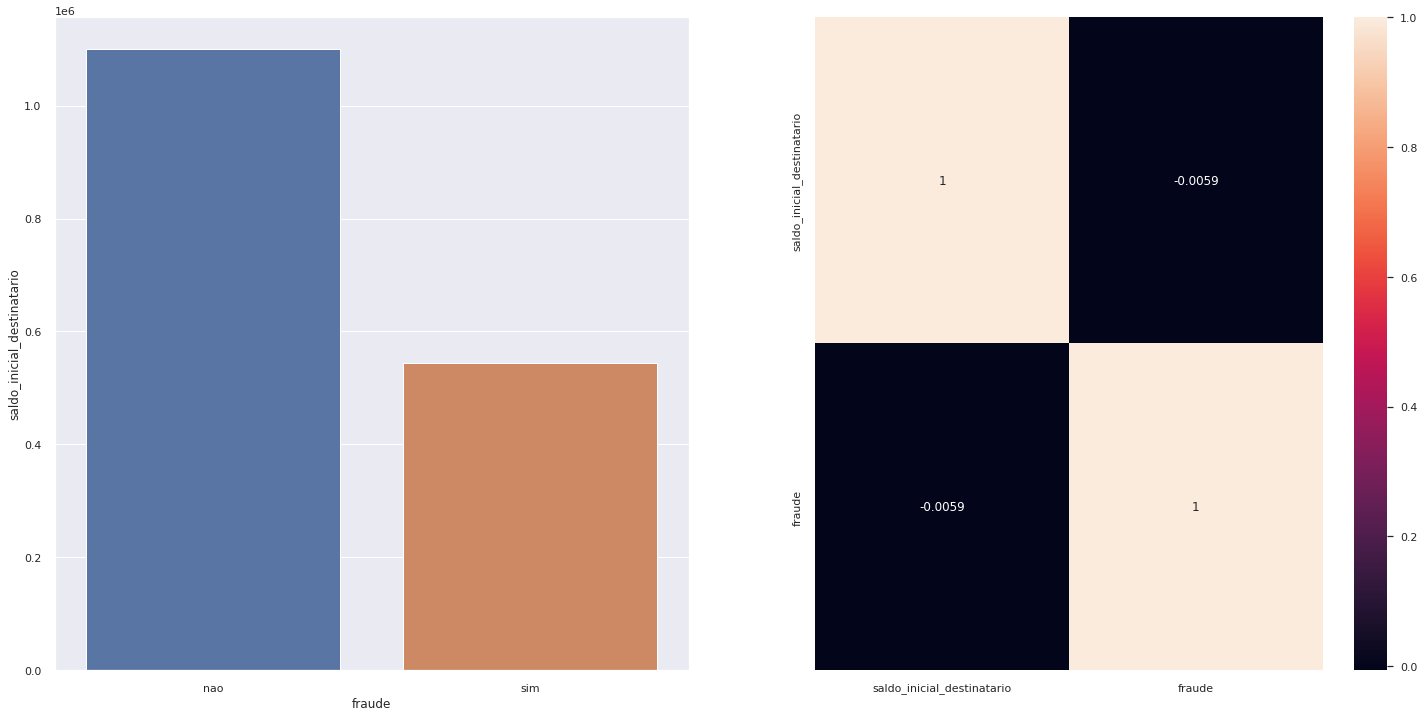

In [ ]:
numeric_categorical(df4,'saldo_inicial_destinatario','fraude')

### ***H2***. Quanto maior o saldo atual do destinatário, maior é a chance de fraude.(FALSE)

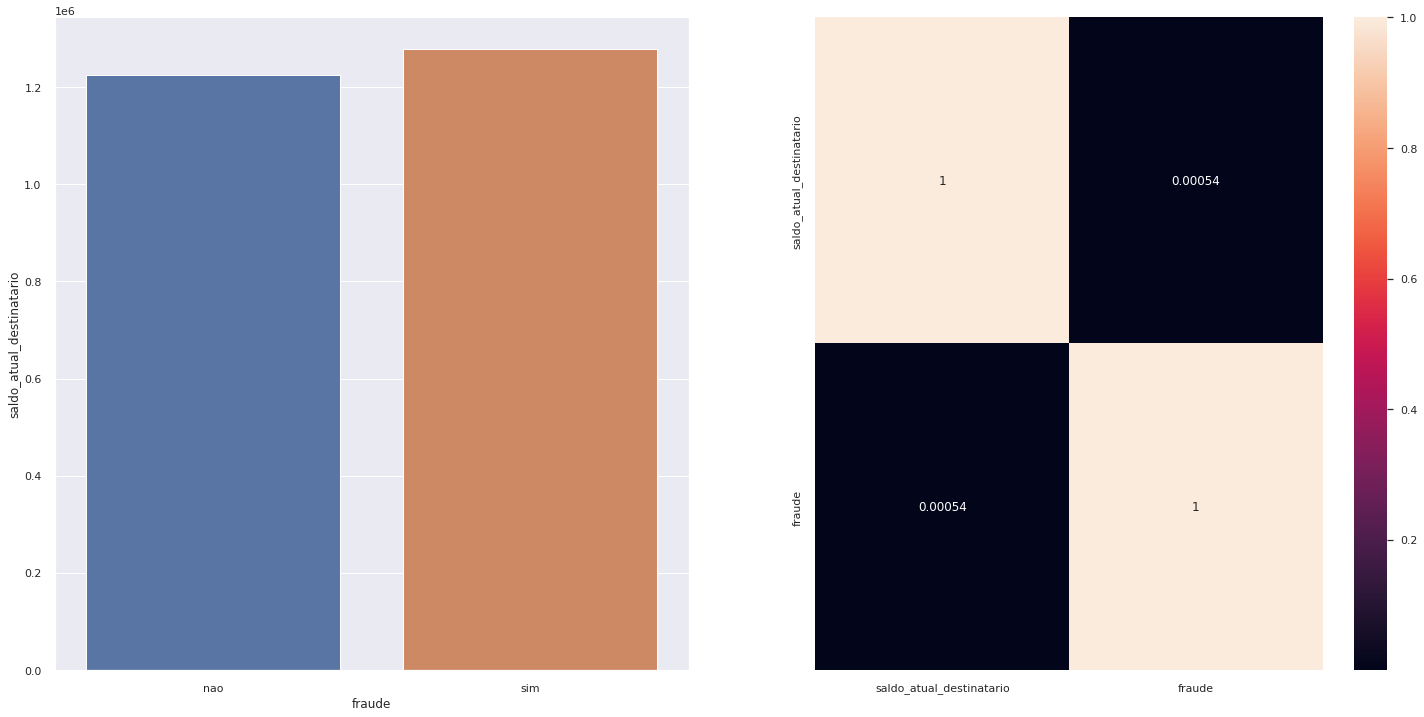

In [ ]:
numeric_categorical(df4,'saldo_atual_destinatario','fraude')

### ***H3***. Quanto maior o saldo inicial do remetente , maior é a chance de fraude. (TRUE)

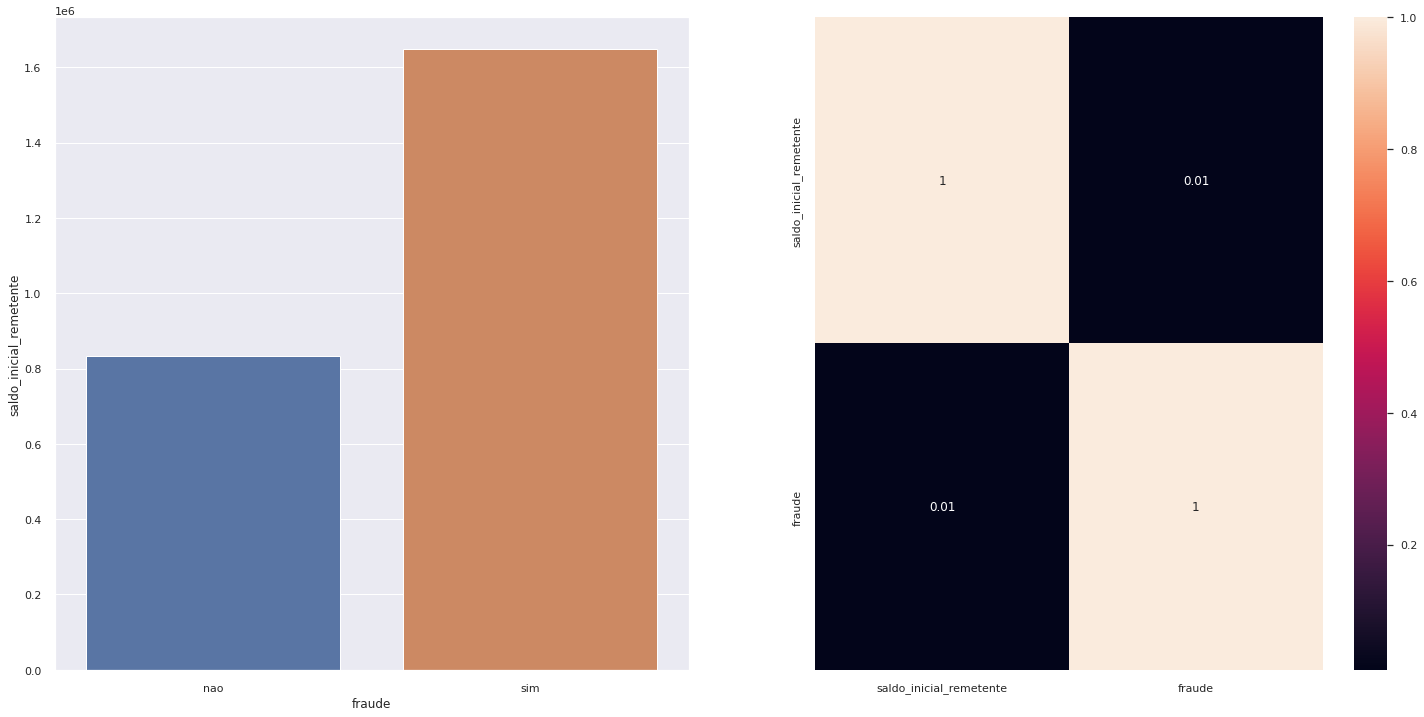

In [ ]:
numeric_categorical(df4,'saldo_inicial_remetente','fraude')

### ***H4***. Quanto maior o saldo atual do remetente , maior é a chance de fraude. (FALSE)

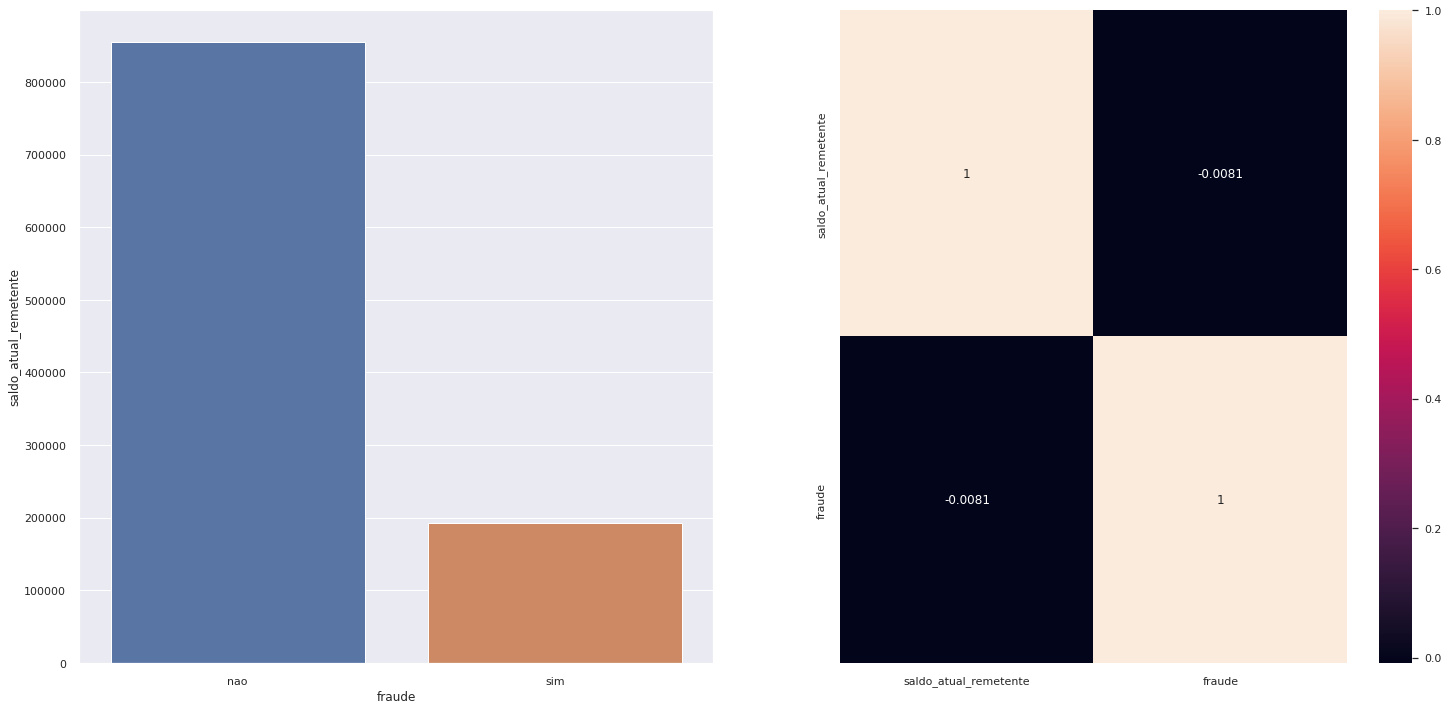

In [ ]:
numeric_categorical(df4,'saldo_atual_remetente','fraude')

### ***H5***. Quanto maior o valor do montante , maior é a chance de fraude. (TRUE)


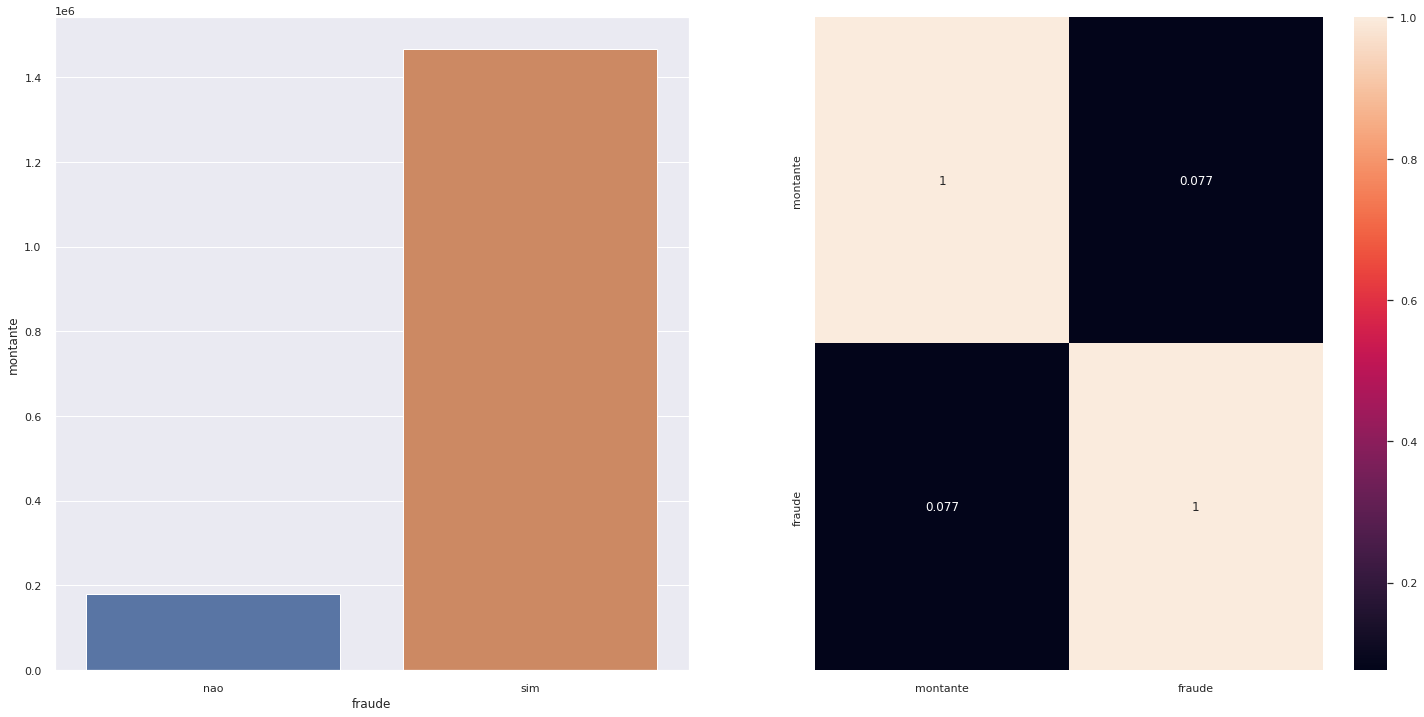

In [ ]:
numeric_categorical(df4,'montante','fraude')

### ***H6***. Quanto maior  a etapa de medição, maior é a chance de fraude. (TRUE)

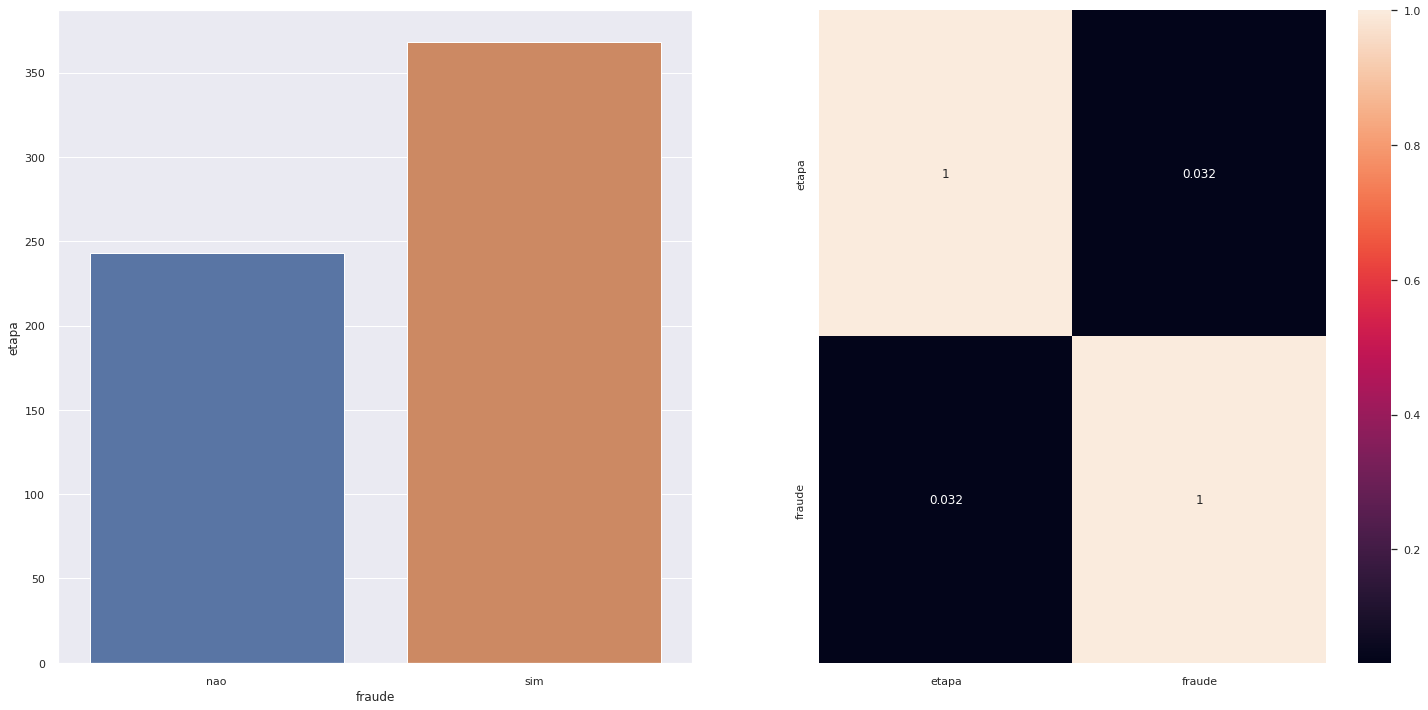

In [ ]:
numeric_categorical(df4,'etapa','fraude')

### 4.3.1 Summary of hypotheses

In [ ]:
#dataframe com o resumo das hipoteses
tab=[['Hipoteses','conclusao','Relevancia'],
     ['H1','Falsa','Media'],
     ['H2','Falsa','Baixa'],
     ['H3','Verdadeira','Alta'],
     ['H4','Falsa','Baixa'],
     ['H5','Verdadeira','Alta'],
     ['H6','Verdadeira','Media']]

print(tabulate(tab,headers='firstrow'))

Hipoteses    conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Media
H2           Falsa        Baixa
H3           Verdadeira   Alta
H4           Falsa        Baixa
H5           Verdadeira   Alta
H6           Verdadeira   Media


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Atributes

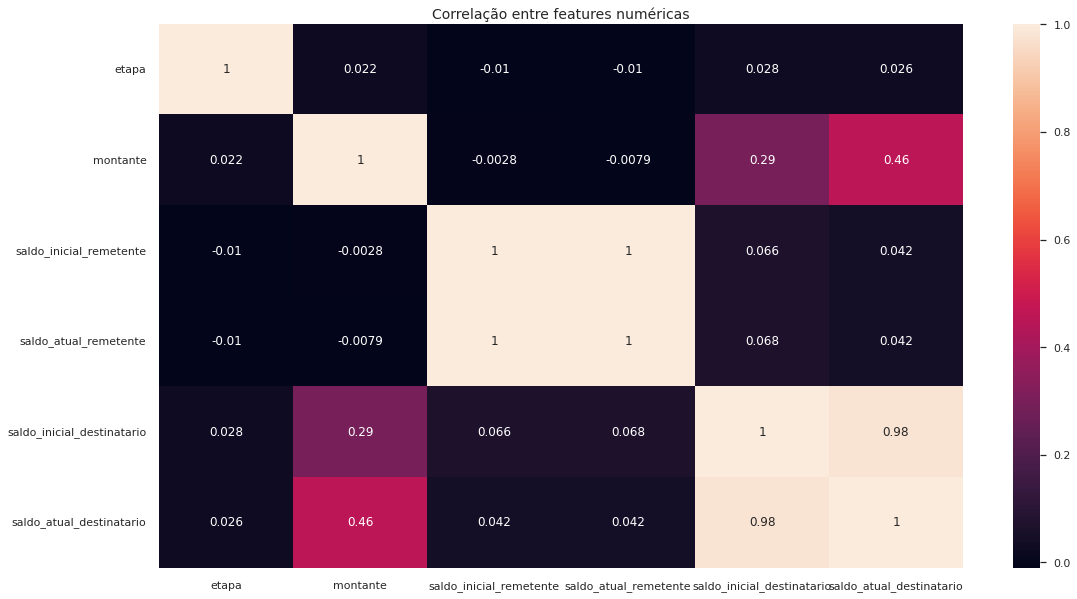

In [ ]:
#grafico de correlacao
correlacao_features_numericas(num_attributes,df4)

### 4.3.2. Categorical Atributes

In [ ]:
lista=correlacao_categorica(df4[df4.index<10000])

d=pd.DataFrame({'tipos':                           lista[0],
                'remetente':                       lista[1],
                'destinatario':                    lista[2],
                'fraude':                          lista[3],
                'fraude_sinalizada':               lista[4], 
                'alerta_montante':                 lista[5],
                'alerta_etapa':                    lista[6],
                'alerta_saldo_inicial_remetente':  lista[7]             
                })

d=d.set_index(d.columns)

d

,tipos,remetente,destinatario,fraude,fraude_sinalizada,alerta_montante,alerta_etapa,alerta_saldo_inicial_remetente
tipos,1.000200,inf,0.663502,0.156185,NaN,0.479162,NaN,0.838592
remetente,inf,inf,inf,inf,NaN,inf,NaN,inf
destinatario,0.663502,inf,1.665836,0.768233,NaN,0.582777,NaN,0.616771
fraude,0.156185,inf,0.768233,0.992646,NaN,0.018320,NaN,0.020884
fraude_sinalizada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alerta_montante,0.479162,inf,0.582777,0.018320,NaN,0.999444,NaN,0.073196
alerta_etapa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alerta_saldo_inicial_remetente,0.838592,inf,0.616771,0.020884,NaN,0.073196,NaN,0.999675


# 5.0. PASSO 5 - DATA PREPARATION

In [ ]:
#copia do dataframe
df5=df4.copy()

## 5.1. Rescaling

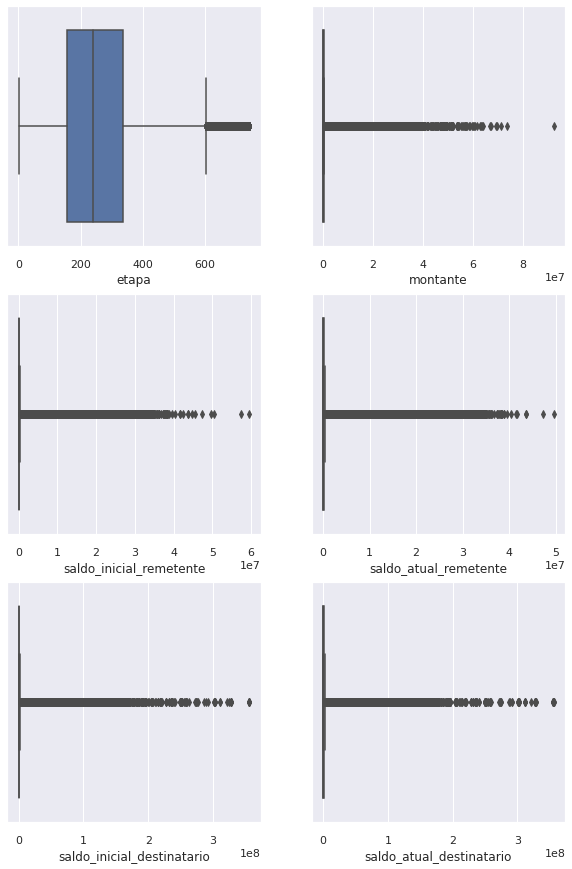

In [ ]:
#num_attributes e cat_attributes
num_attributes=df5.select_dtypes(include=['int64','float64'])
cat_attributes=df5.select_dtypes(include='object')

#grafico para verificacao de outliers
columns=num_attributes.columns

for i in range(0,len(columns)):

  plt.subplot(3,2,i+1)
  ax=sns.boxplot(num_attributes[columns[i]])
  ax.figure.set_size_inches(10,15)

In [ ]:
#outliers
muitos_outliers=['saldo_inicial_destinatario','saldo_atual_destinatario',
                 'saldo_inicial_remetente','saldo_atual_remetente']
poucos_outliers=['etapa']

#rescaling
df5=rescaling(poucos_outliers,muitos_outliers,df5)

## 5.2. Transformation

### 5.3.1. Encoding

In [ ]:
#Label Encoding
#tipos
le=LabelEncoder()
df5['tipos']=le.fit_transform(df5['tipos'])

#cliente_remetente
df5['remetente']=le.fit_transform(df5['remetente'])

#cliente_destinatario
df5['destinatario']=le.fit_transform(df5['destinatario'])

#fraude
df5['fraude']=le.fit_transform(df5['fraude'])


#One Hot Encoding
#fraude_sinalizada
df5=pd.get_dummies(df5,prefix=['fraude_sinalizada'],columns=['fraude_sinalizada'])

#alerta_montante
df5=pd.get_dummies(df5,prefix=['alerta_montante'],columns=['alerta_montante'])

#alerta_etapa
df5=pd.get_dummies(df5,prefix=['alerta_etapa'],columns=['alerta_etapa'])

#alerta_saldo_inicial_remetente
df5=pd.get_dummies(df5,prefix=['alerta_saldo_inicial_remetente'],columns=['alerta_saldo_inicial_remetente'])

In [ ]:
#transformation
#montante
df5['montante']=np.log1p(df5['montante'])

# 6.0. PASSO 6 - FEATURE SELECTION

In [ ]:
#copia do dataframe
df6=df5.copy()

## 6.1. Split dataframe into training and test dataset.

In [ ]:
#split train and test
aux=df6[df6.index>=6000000].copy()
Y_b=aux['fraude']
X_b=aux.drop(['fraude',],axis=1)

x_train_b,x_test_b,y_train_b,y_test_b=train_test_split(X_b,Y_b,test_size=0.3,random_state=2811)

##6.2. Boruta as feature selector


In [ ]:
boruta=boruta(x_train_b,y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	8


###6.2.1. Best Features from Boruta

In [ ]:
best_features(boruta,x_train_b)

['etapa',
 'tipos',
 'montante',
 'saldo_inicial_remetente',
 'saldo_atual_remetente',
 'destinatario',
 'saldo_atual_destinatario',
 'alerta_saldo_inicial_remetente_0',
 'alerta_saldo_inicial_remetente_1']

##6.3. Manual Feature selection


In [ ]:
cols_selected_boruta=['etapa','tipos','montante','saldo_inicial_remetente',
                      'saldo_atual_remetente','destinatario','saldo_atual_destinatario']

#Columns to add
feat_to_add=['fraude']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [ ]:
#Filtrando as features mais importantes
df=df6[cols_selected_boruta_full].copy()

#Separando os dados para o desbalanceamento
Y=df['fraude']
X=df.drop(['fraude',],axis=1)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=2811)
#NearMiss
nr=NearMiss()
x_train_nm,y_train_nm=nr.fit_resample(x_train,y_train)
x_test_nm,y_test_nm=nr.fit_resample(x_test,y_test)
#Concat
aux1=pd.DataFrame(data=x_train_nm,columns=x_train.columns)
aux1['fraude']=y_train_nm
aux2=pd.DataFrame(data=x_test_nm,columns=x_test.columns)
aux2['fraude']=y_test_nm
df=pd.concat([aux1,aux2],axis=0)

#Ordenando os frames
y=df['fraude']
x=df.drop(['fraude'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=2811)

#Dataset cross validation
aux1=pd.DataFrame(data=y_train,columns=['fraude'])
aux1=pd.concat([x_train,aux1],axis=1)
aux2=pd.DataFrame(data=y_test,columns=['fraude'])
aux2=pd.concat([x_test,aux2],axis=1)
df7=pd.concat([aux1.reset_index(drop=True), aux2.reset_index(drop=True)], axis= 0)

Feature: 0, Score: 0.00867
Feature: 1, Score: 0.00295
Feature: 2, Score: 0.23261
Feature: 3, Score: 0.49933
Feature: 4, Score: 0.21043
Feature: 5, Score: 0.00541
Feature: 6, Score: 0.04060


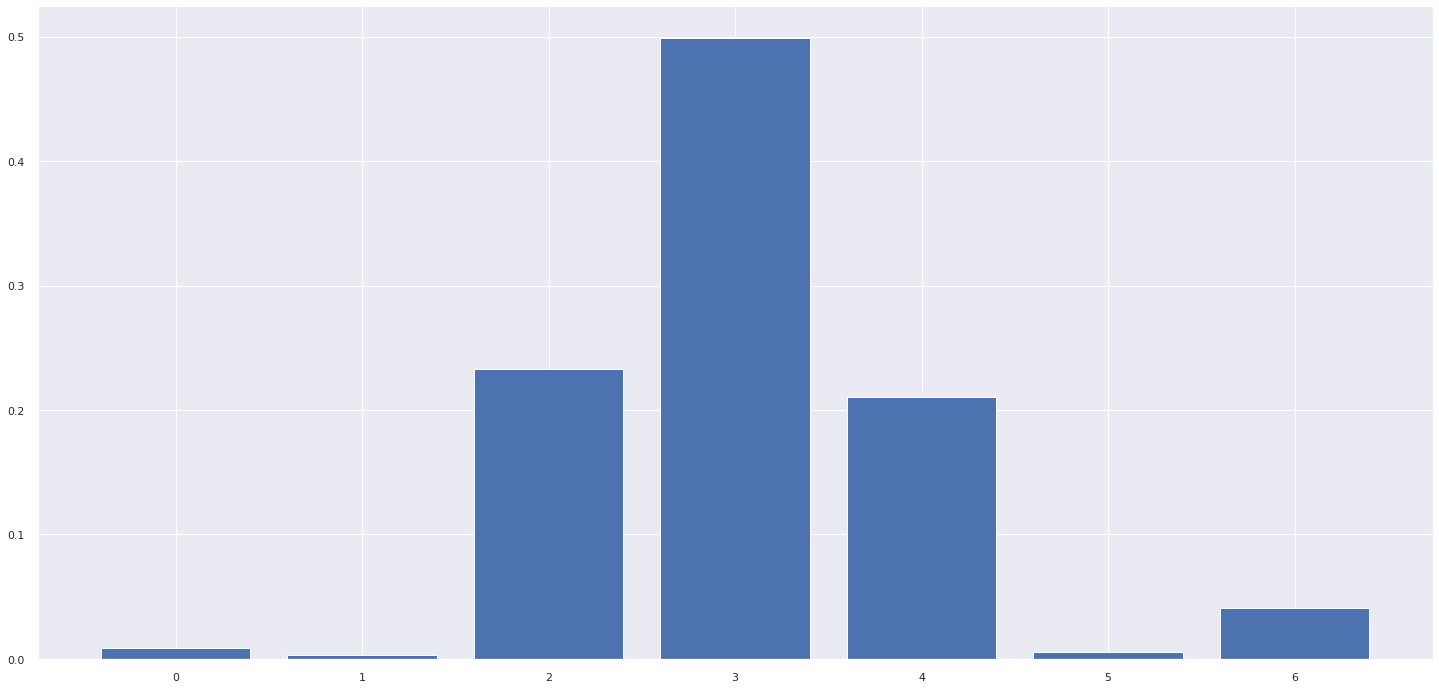

In [ ]:
#Identificando as melhores features
feature_importance(x_train,y_train)

##7.1. Base Line

In [ ]:
#model
dc = DummyClassifier()
dc_train=dc.fit(x_train,y_train)

#predict
yhat_dc=dc_train.predict(x_test)

#performance
dc_result=model_perform(y_test,yhat_dc,'baseline')
dc_result

,model Name,accuracy,precision,recall,f1 score
0,baseline,0.491274,0.486928,0.491246,0.487426


## 7.2. PyCaret

In [ ]:
#Dataset de treino
X_TRAIN=x_train.copy()
X_TRAIN['Fraude']=y_train

#Setup
s=setup(  X_TRAIN[[ 'etapa', 'tipos', 'montante', 'saldo_inicial_remetente',
                    'saldo_atual_remetente', 'destinatario', 'saldo_atual_destinatario',
                    'Fraude']],
        target='Fraude',
        numeric_features=['montante','saldo_inicial_remetente','saldo_atual_remetente','saldo_atual_destinatario'],
        normalize=True,
        normalize_method='minmax',
        data_split_stratify=True,
        )
#Best models
best=compare_models(fold=5,sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9917,0.9992,0.9946,0.9889,0.9917,0.9833,0.9834,0.280
rf,Random Forest Classifier,0.9879,0.9989,0.9933,0.9829,0.9881,0.9759,0.9760,1.024
gbc,Gradient Boosting Classifier,0.9852,0.9983,0.9948,0.9762,0.9854,0.9704,0.9706,1.040
et,Extra Trees Classifier,0.9820,0.9980,0.9844,0.9798,0.9821,0.9640,0.9640,0.786
ada,Ada Boost Classifier,0.9744,0.9967,0.9829,0.9667,0.9747,0.9488,0.9490,0.388
dt,Decision Tree Classifier,0.9830,0.9830,0.9829,0.9832,0.9830,0.9660,0.9660,0.044
knn,K Neighbors Classifier,0.8465,0.9047,0.8208,0.8665,0.8429,0.6932,0.6942,0.212
nb,Naive Bayes,0.6023,0.9030,1.0000,0.5579,0.7162,0.2021,0.3350,0.032
lda,Linear Discriminant Analysis,0.7996,0.8688,0.7529,0.8319,0.7904,0.5993,0.6021,0.040
lr,Logistic Regression,0.7901,0.8520,0.7707,0.8033,0.7867,0.5803,0.5809,1.352


#8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

In [ ]:
#copia do dataframe
df8=df7.copy()

##8.1.Random Search

In [ ]:
#params
params={       'criterion':           ['gini','entropy'],
               'max_depth':            range(1,10),
               'min_samples_split':    range(2,11),
               'min_samples_leaf':     range(1,5)}

#model
rfc=RandomForestClassifier()

rscv = RandomizedSearchCV(rfc, params, random_state=0,cv=3,n_iter=100).fit(x_train, y_train)
rscv.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 6}

##8.2.Final Model

In [ ]:
#params tuned
params_tuned={      'criterion': 'entropy',
                    'max_depth': 9,
                    'min_samples_leaf': 4,
                    'min_samples_split': 5}

#model
model_rfc_tuned=RandomForestClassifier(     criterion=          params_tuned['criterion'],
                                            max_depth=          params_tuned['max_depth'],
                                            min_samples_split=  params_tuned['min_samples_split'],
                                            min_samples_leaf=   params_tuned['min_samples_leaf'])


#training
model_rfc_train=model_rfc_tuned.fit(x_train,y_train)

#prediction
yhat_rfc_tuned=model_rfc_train.predict(x_test)

#performance
rfc_result_cv=cross_validation(df8,5,'RandomForestClassifier',model_rfc_tuned)
rfc_result_cv

,Model name,accuracy CV,precision CV,recall CV,f1 score CV
0,RandomForestClassifier,0.98+/-0.0,0.97+/-0.01,0.98+/-0.0,0.98+/-0.0


#9.0. PASSO 9 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [ ]:
df9=df8.copy()

##9.1. Machine Learning Performance

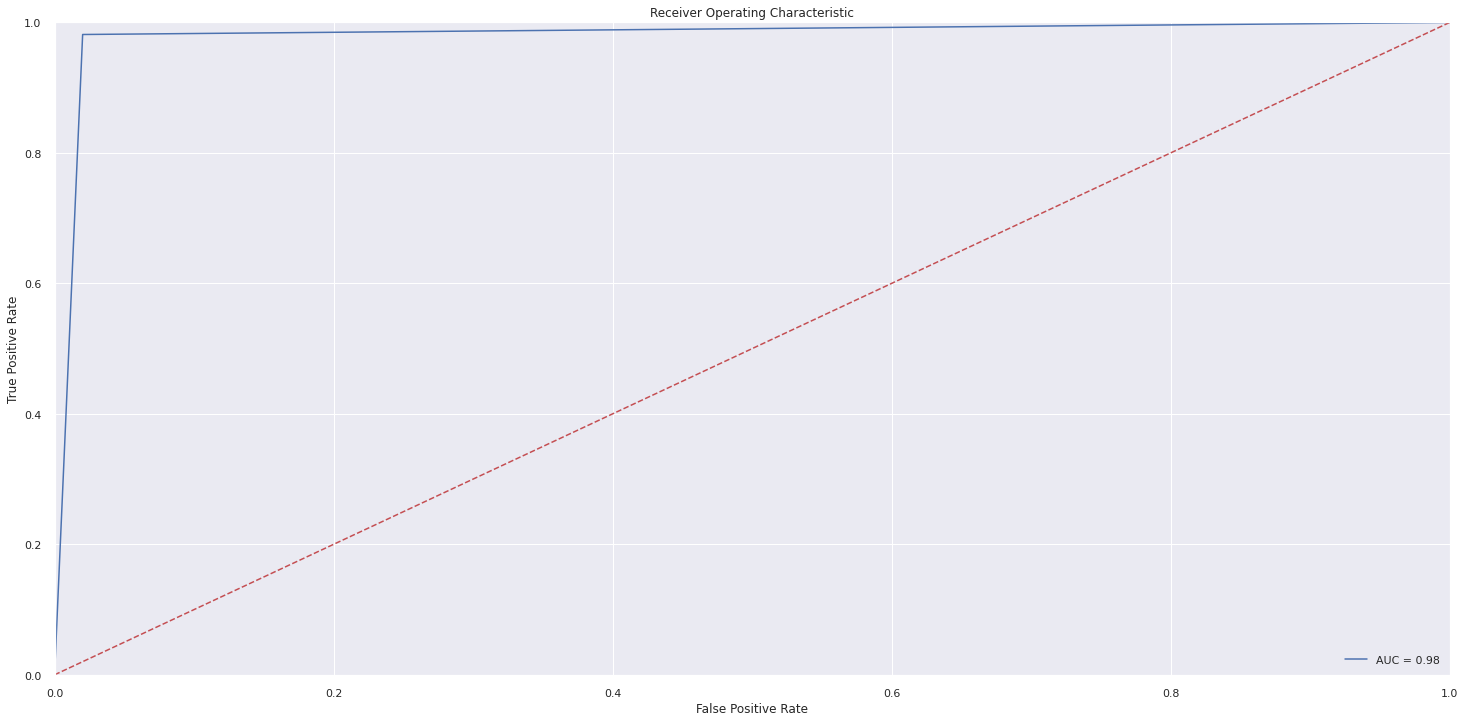

In [ ]:
#AUC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_rfc_tuned)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

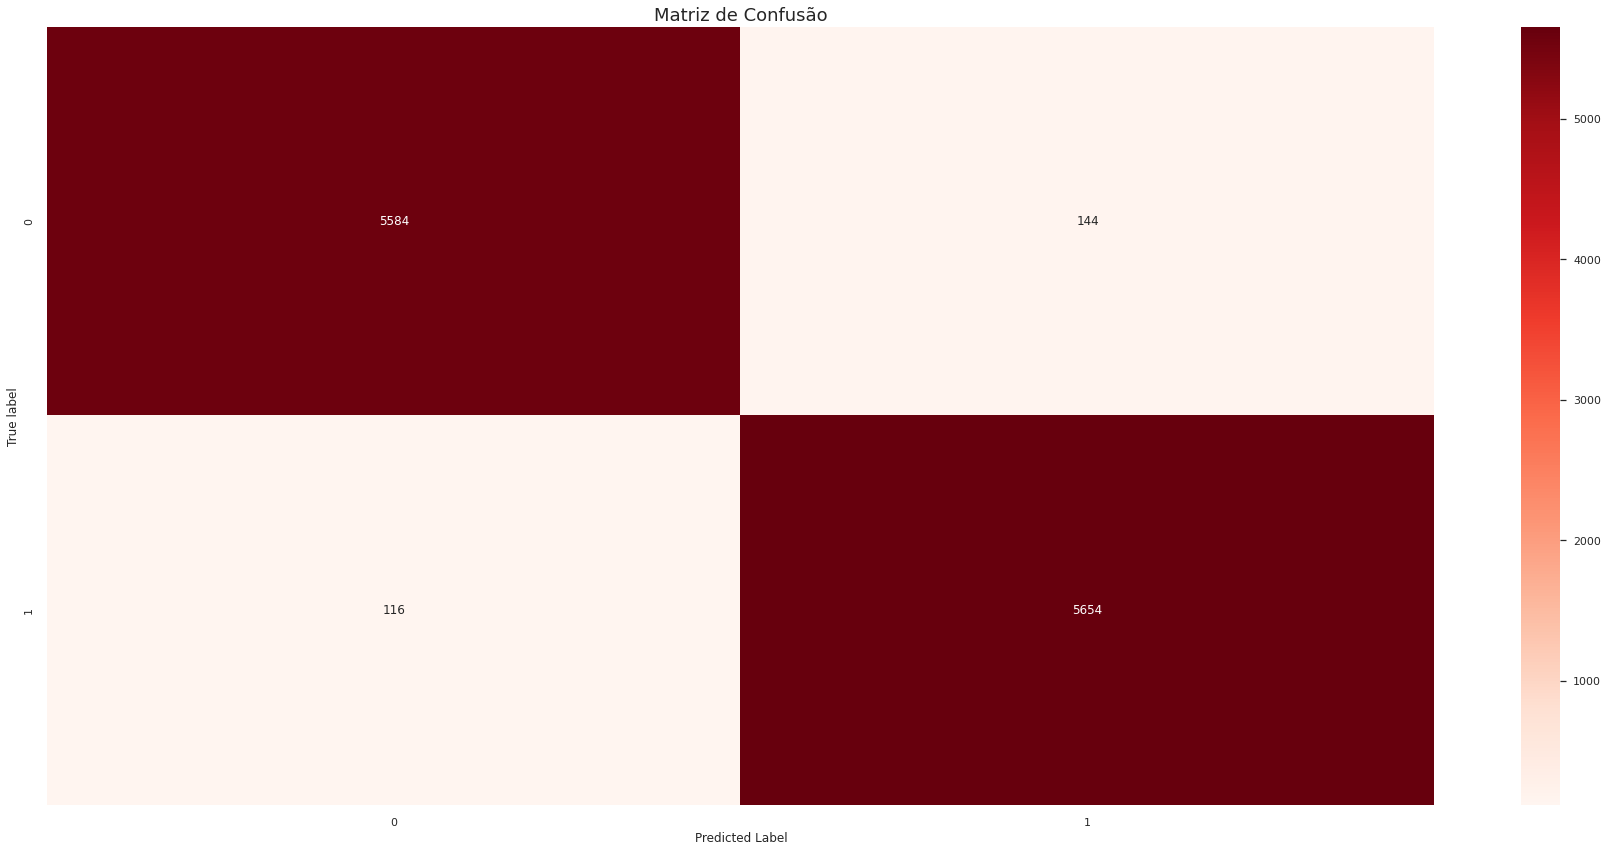

In [ ]:
#Matriz de Confusão
np.random.seed(2811)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(model_rfc_tuned , x_train, y_train, cv = cv)


fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

##9.1. Business Performance

###9.1.1 Respondendo a perguntas propostas

####Qual a Precisão e Acurácia do modelo?

In [ ]:
print('Precisão: {} e Acurácia: {}'.format(0.97,0.98))

Precisão: 0.97 e Acurácia: 0.98


####Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?

In [ ]:
print('Confiabilidade: {}'.format(0.98))

Confiabilidade: 0.98


####Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?

In [ ]:
#Dataset
x_test['montante']=np.expm1(x_test['montante'])
aux=x_test.copy()
aux['fraude']=yhat_rfc_tuned
aux['true']=y_test
aux=aux[['montante','fraude','true']]

esperado=aux[aux['fraude']==1]['montante'].sum()*0.25
total=aux['montante'].sum()
percentual=(esperado*100)/total
print('Percentual de faturamento em relação ao montante: {} %'.format(round(percentual,2)))

Percentual de faturamento em relação ao montante: 21.5 %


####Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?

In [ ]:
#Dataset
aux['fraude3']=yhat_rfc_tuned
aux['true']=y_test
aux=aux[['montante','fraude3','true']]

#25%
erro1=aux[(aux['fraude3']==1)&(aux['true']==0)]['montante'].sum()*0.05
erro1

#5%
acertos=aux[(aux['fraude3']==1)&(aux['true']==1)]['montante'].sum()*0.25
acertos

#100%
erro2=aux[(aux['fraude3']==0)&(aux['true']==1)]['montante'].sum()
erro2

total=aux['montante'].sum()
ganhos=erro1+acertos
perdas=erro2

print('Perda percentual em relação ao montante:  {} %'.format(round((perdas*100)/total,2)))

Perda percentual em relação ao montante:  0.1 %


####Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

* A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
* A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
* A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.

In [ ]:
print('Ganho percentual em relação ao montante:  {} %'.format(round((ganhos*100)/total,2)-round((perdas*100)/total,2)))

Ganho percentual em relação ao montante:  21.34 %


#10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

##10.1.transformacões class

In [ ]:
'''import pandas as pd
from sklearn.preprocessing   import RobustScaler,MinMaxScaler,LabelEncoder

def transformacoes(data):

  columns={   'step':'etapa','type':'tipos','amount':'montante','nameOrig':'remetente',
              'oldbalanceOrg':'saldo_inicial_remetente','newbalanceOrig':'saldo_atual_remetente',
              'nameDest':'destinatario','oldbalanceDest':'saldo_inicial_destinatario',
              'newbalanceDest':'saldo_atual_destinatario','isFraud':'fraude','isFlaggedFraud':'fraude_sinalizada'}

  data=data.rename(columns=columns)

  data['fraude']=data['fraude'].apply(lambda x:'sim' if x==1.0 else 'nao')

  data=data[data.index !=42270]

  data['fraude_sinalizada']=data['fraude_sinalizada'].astype(str)

  rs=RobustScaler()
  mms=MinMaxScaler()

  #MinMaxScaler
  #etapa
  data['etapa']=mms.fit_transform(data[['etapa']].values)

  #RobustScaler
  #montante
  data['montante']=rs.fit_transform(data[['montante']].values)

  #saldo_inicial_remetente
  data['saldo_inicial_remetente']=rs.fit_transform(data[['saldo_inicial_remetente']].values)

  #saldo_atual_remetente
  data['saldo_atual_remetente']=rs.fit_transform(data[['saldo_atual_remetente']].values)

  #saldo_inicial_destinatario
  data['saldo_inicial_destinatario']=rs.fit_transform(data[['saldo_inicial_destinatario']].values)

  #saldo_atual_destinatario
  data['saldo_atual_destinatario']=rs.fit_transform(data[['saldo_atual_destinatario']].values)

  #Label Encoding
  #tipo
  le=LabelEncoder()
  data['tipos']=le.fit_transform(data['tipos'])

  #cliente_remetente
  data['remetente']=le.fit_transform(data['remetente'])

  #cliente_destinatario
  data['destinatario']=le.fit_transform(data['destinatario'])

  #One Hot Encoding 
  #fraude
  data['fraude']=data['fraude'].apply(lambda x: 1 if x=='sim' else 0)

  data=data[['etapa','tipos','montante','saldo_inicial_remetente',
             'saldo_atual_remetente','destinatario','saldo_atual_destinatario']]
  return data
 
def get_prediction(model,dado_original,data_transforme):
  #prediction
  pred=model.predict(data_transforme)

  #join pred into the original data
  dado_original['predicoes']=pred

  return dado_original.to_json(orient='records',date_format='iso')'''

##10.2.API Handler

In [ ]:
'''from flask                         import Flask,request,Response
from transformacoes.transformacoes import transformacoes
from transformacoes.transformacoes import get_prediction
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/model_rfc_train.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #transformacoes    
    data=transformacoes(test_raw)
    
    #predict
    df_response=get_prediction(model,test_raw,data)
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

##10.3. API Tester

In [ ]:
#filtrando a linha da predicap
df_test_deploy=df_test_deploy[df_test_deploy.index.isin([2,3,251,252,680,681,724,969,970])]

#converter em json
df_test_deploy=json.dumps(df_test_deploy.to_dict(orient='records'))

In [ ]:
#API call
url='https://nvnvnbbbbbb.herokuapp.com/oi'
headers={'content-type':'application/json'}
data=df_test_deploy
r=requests.post(url,data=data,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [ ]:
#Prediction
df1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df1=df1.drop(['isFraud'],axis=1)
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,predicoes
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,0,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,0,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,0,1
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,0,1
4,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,0,1
5,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,0,1
6,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,0,0
7,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,0,1
8,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,0,1
